### Figure S9: Drivers of mixing component

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33655/status,
Dashboard: /proxy/33655/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34173,Workers: 0
Dashboard: /proxy/33655/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43061,Total threads: 1
Dashboard: /proxy/46555/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:43141,


2025-11-21 13:56:42,938 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:39741 (pid=666273) exceeded 95% memory budget. Restarting...
2025-11-21 13:56:43,433 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39741' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('where-658e951fcca9e023fb3087bc6ace4606', 324, 1, 1, 4), ('rechunk-split-742bed5f6c2850a67e140716d733f68f', 118575), ('groupby-cohort-2bae452ef4dc96b1d7355f04918bd015', 1, 1, 2, 5), ('rechunk-split-742bed5f6c2850a67e140716d733f68f', 115695), ('rechunk-split-742bed5f6c2850a67e140716d733f68f', 114975), ('rechunk-split-742bed5f6c2850a67e140716d733f68f', 110655), ('where-658e951fcca9e023fb3087bc6ace4606', 312, 2, 2, 3), ('rechunk-merge-38331bce130fde22da4d25441539c482', 461, 0, 1, 3), ('rechunk-merge-38331bce130fde22da4d25441539c482', 322, 0, 2, 4), ('rechunk-merge-38331bce130fde22da4d25441539c482', 219, 0, 2, 3), ('rechunk-merge-38331bce130fde22da4d25441539

In [3]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [4]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [37]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
salt = exp_ds.search(variable=['salt'],frequency='1mon').to_dask()['salt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))
temp_xf = exp_ds.search(variable='temp_xflux_adv',frequency='1mon').to_dask()['temp_xflux_adv'].sel(yt_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
temp_yf = exp_ds.search(variable='temp_yflux_adv',frequency='1mon').to_dask()['temp_yflux_adv'].sel(yu_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))
w = exp_ds.search(variable='wt',frequency='1mon').to_dask()['wt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
salt_ext = ext_ds.search(variable=['salt'],frequency='1mon').to_dask()['salt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))
temp_xf_ext = ext_ds.search(variable='temp_xflux_adv',frequency='1mon').to_dask()['temp_xflux_adv'].sel(yt_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
temp_yf_ext = ext_ds.search(variable='temp_yflux_adv',frequency='1mon').to_dask()['temp_yflux_adv'].sel(yu_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))
w_ext = ext_ds.search(variable='wt',frequency='1mon').to_dask()['wt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))


In [38]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
salt_full = xr.concat((salt,salt_ext),dim='time')
temp_xf_full = xr.concat((temp_xf,temp_xf_ext),dim='time')
temp_yf_full = xr.concat((temp_yf,temp_yf_ext),dim='time')
w_full = xr.concat((w,w_ext),dim='time')
# Calculate annual
t_an = temp_full.resample({'time':'Y'}).mean('time')
salt_an = salt_full.resample({'time':'Y'}).mean('time')
temp_xf_an = temp_xf_full.resample({'time':'Y'}).mean('time')
temp_yf_an = temp_yf_full.resample({'time':'Y'}).mean('time')
w_an = w_full.resample({'time':'Y'}).mean('time')


In [39]:
import gsw
# Calculate pressure
pressure = gsw.p_from_z(salt_an.st_ocean[0], salt_an.yt_ocean).rename('pressure')

# Calculate surface absolute salinity
SA = gsw.SA_from_SP(salt_full.isel(st_ocean=0), pressure, salt_an.xt_ocean, salt_an.yt_ocean).rename('SA')


In [7]:
# Get net surface heat flux: Sum of variables "net_sfc_heating" and "frazil_3d_int_z"

net_shf = exp_ds.search(variable=['net_sfc_heating'],frequency='1mon').to_dask()['net_sfc_heating'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))+exp_ds.search(variable=['frazil_3d_int_z'],frequency='1mon').to_dask()['frazil_3d_int_z'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))

net_shf_ext = ext_ds.search(variable=['net_sfc_heating'],frequency='1mon').to_dask()['net_sfc_heating'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))+ext_ds.search(variable=['frazil_3d_int_z'],frequency='1mon').to_dask()['frazil_3d_int_z'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))

net_shf_full = xr.concat((net_shf,net_shf_ext),dim='time')
net_shf_an = net_shf_full.resample({'time':'Y'}).mean('time').load()

In [40]:
# Get net surface salt flux: Freshwater flux (PmE) times salt - salt flux (sfc_salt_flux_ice+sfc_salt_flux_restore)

pme = exp_ds.search(variable=['pme_net'],frequency='1mon').to_dask()['pme_net'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))

salt_flux = exp_ds.search(variable=['sfc_salt_flux_ice'],frequency='1mon').to_dask()['sfc_salt_flux_ice'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))+exp_ds.search(variable=['sfc_salt_flux_restore'],frequency='1mon').to_dask()['sfc_salt_flux_restore'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))

pme_ext = ext_ds.search(variable=['pme_net'],frequency='1mon').to_dask()['pme_net'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))

salt_flux_ext = ext_ds.search(variable=['sfc_salt_flux_ice'],frequency='1mon').to_dask()['sfc_salt_flux_ice'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))+ext_ds.search(variable=['sfc_salt_flux_restore'],frequency='1mon').to_dask()['sfc_salt_flux_restore'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))

pme_full = xr.concat((pme,pme_ext),dim='time')
pme_an = pme_full.resample({'time':'Y'}).mean('time')

salt_flux_full = xr.concat((salt_flux,salt_flux_ext),dim='time')
salt_flux_an = salt_flux_full.resample({'time':'Y'}).mean('time')

In [41]:
net_salt_flux = (pme_full*SA-salt_flux_full*1000).resample({'time':'Y'}).mean().load()

In [16]:
# Sea ice for cycle4 is split up into two different file IDs that we need to concatenate

hi = exp_ds.search(variable=['hi_m'],frequency='1mon',file_id='seaIce.1mon.d2:2.nc:5.ni:3600.nj:2700').to_dask(
            xarray_open_kwargs={
                "chunks": -1 ,
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850)).sel(time = slice(start,end))

hi2 = exp_ds.search(variable=['hi_m'],frequency='1mon',file_id='seaIce.1mon.d2:2.nc:5.ni:3600.nj:2700.nkice:4').to_dask(
            xarray_open_kwargs={
                "chunks": -1 ,
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850)).sel(time = slice(start,end))

hi_ext = ext_ds.search(variable=['hi_m'],frequency='1mon',file_id='seaIce.1mon.d2:2.nc:5.ni:3600.nj:2700').to_dask(
            xarray_open_kwargs={
                "chunks": -1 ,
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850)).sel(time = slice(start_ext,end_ext))

hi_full = xr.concat([hi[:361], hi2, hi[361:],hi_ext[:-1]],dim='time')
hi_an = hi_full.resample({'time':'Y'}).mean('time')

# Assign lat-lon coordinates
hi_an.coords['ni'] = t_an.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['xt_ocean'].values
hi_an.coords['nj'] = t_an.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['yt_ocean'].values
hi_an.coords['time'] = t_an.time
hi_an = hi_an.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [17]:
# Calculate heat flux amplitude:
txf_u = temp_xf_an.rename({'yt_ocean':'yu_ocean'}).assign_coords(yu_ocean = temp_yf_an.yu_ocean)
tyf_u = temp_yf_an.rename({'xt_ocean':'xu_ocean'}).assign_coords(xu_ocean = temp_xf_an.xu_ocean)
temp_flux = np.sqrt(txf_u**2+tyf_u**2)

In [18]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [19]:
# Calculate temperature tendency 
cp = 4000
rho0 = 1025
temp_ten = (cp*rho0*thickness*area_t*temp_full.chunk(time=-1).differentiate('time',datetime_unit='s')) 


In [20]:
above1000 = ht.where(ht>=1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000) # remove all values bigger than 1000
above1000_tcells = xr.where(((above1000_tcells.xt_ocean<-111) & (above1000_tcells.yt_ocean<-72.6)),np.nan,above1000_tcells) # remove southwest corner that is dynamically part of the Dotson-Getz trough controlled area

In [21]:
# Compute horizontal convergence
zonal_adv = (((temp_xf_full.shift(xu_ocean=1).fillna(0)-temp_xf_full.fillna(0)))).rename({'xu_ocean':'xt_ocean'})
meridional_adv = (((temp_yf_full.shift(yu_ocean=1).fillna(0)-temp_yf_full.fillna(0)))).rename({'yu_ocean':'yt_ocean'})
zonal_adv.coords['xt_ocean'] = meridional_adv.coords['xt_ocean']
meridional_adv.coords['yt_ocean'] = zonal_adv.coords['yt_ocean']


In [22]:
print('Compute vertical convergence')
hflux_w = (temp_full.interp(st_ocean = w_full.sw_ocean.values).rename({'st_ocean': 'sw_ocean'})*w_full.fillna(0)*cp*rho0*area_t).fillna(0)
vert_adv = ((hflux_w-hflux_w.shift(sw_ocean = 1))).rename({'sw_ocean':'st_ocean'})
vert_adv.coords['st_ocean'] = temp_xf_full.coords['st_ocean']

Compute vertical convergence


In [23]:
temp_adv = zonal_adv+meridional_adv+vert_adv
temp_mix = temp_ten - temp_adv

In [31]:
# Load the calculations for the AS region:
temp_ten_as = temp_ten.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean()#.load()
temp_adv_as = temp_adv.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean()#.load()
temp_mix_as = temp_mix.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean().load()

In [25]:
# Load HVE and WMP
# Load WMP on gamma:
wmp_gamma = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_wmp_gamma_on_stocean.nc')['WMP']
hve_gamma = temp_full-temp_full.mean('time')-wmp_gamma

wmp_gamma_an = wmp_gamma.resample({'time':'Y'}).mean()
hve_gamma_an = t_an-t_an.mean('time')-wmp_gamma_an

In [26]:
# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

hve_pibsa = (hve_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pibsa = (wmp_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()

In [27]:
# Load some time series that we will need in the next cell:
wmp_pib_ten = wmp_pibsa.differentiate('time',datetime_unit='s').load()

In [28]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [29]:
# Plot parametres: define projection and boundary path, landmask

xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen for HVE-WMP
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibm = make_boundary_path(lons, lats)
extent_pibm = [minlon,maxlon,minlat,maxlat]
projection_pibm = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


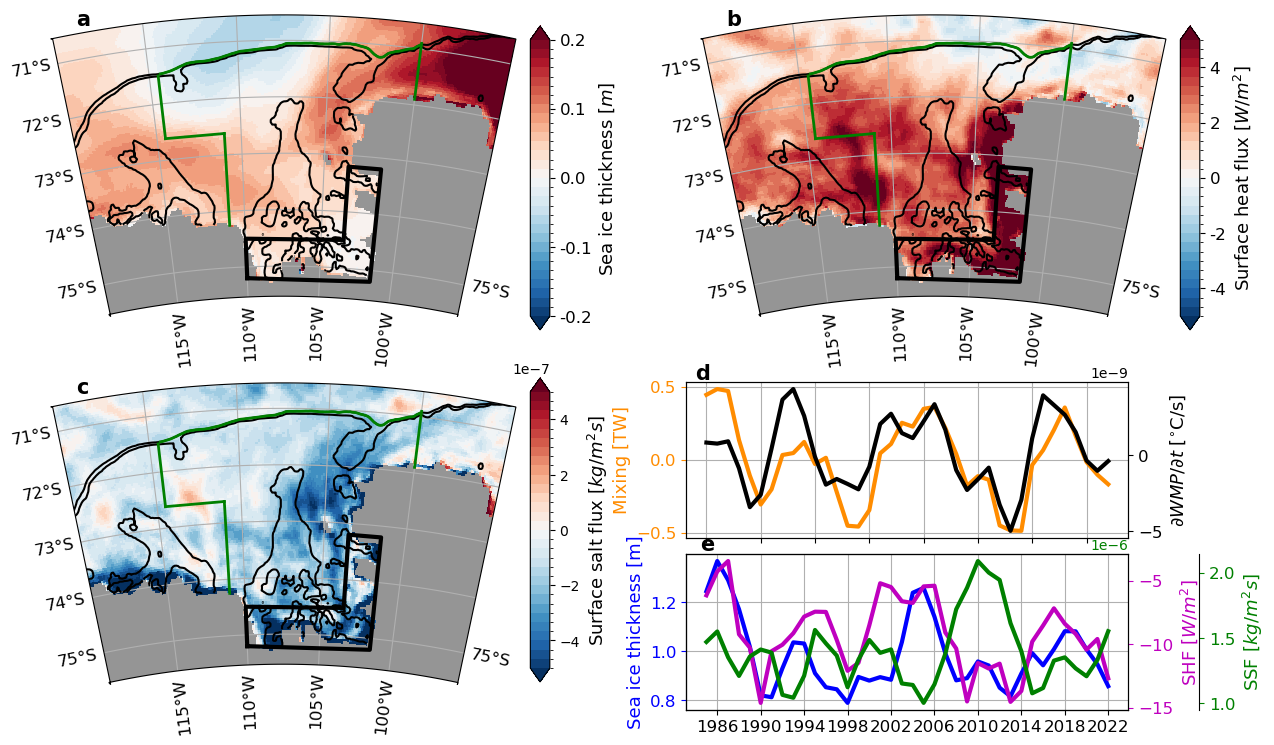

In [42]:
# Same as above but with salt fluxes and surface heat fluxes (full story)
fig = plt.figure(figsize=(13,8))
ax1 = plt.axes([0.53,0.26,0.34,0.195])
axb = ax1.twinx()
((temp_mix_as-temp_mix_as.mean('time'))*above1000_tcells*1e-12).sel(xt_ocean = slice(-114.5,-100)).sum({'st_ocean','xt_ocean','yt_ocean'}).chunk(time=-1).rolling(time=3,center=True).mean().plot(ax=ax1,color='darkorange', lw=3,label='Mixing')
wmp_pib_ten.chunk(time=-1).rolling(time=3,center=True).mean().plot(ax=axb,color='k',lw=3)

ax1.grid()
#ax1.set_ylabel('Sea ice thickness [m]', fontsize=14,color='b')
#ax1.set_xlabel('')
ax1.tick_params('x', colors='k', labelsize=12)
#ax1.tick_params('y', colors='b', labelsize=12)
ax1.tick_params('y', colors='darkorange', labelsize=12)
axb.tick_params('y', colors='k', labelsize=12)
ax1.set_xticks(ticks=hi_an.time[1::5],labels=[])
ax1.set_ylabel('Mixing [TW]', fontsize=13,color='darkorange')
axb.set_ylabel('$\partial WMP/\partial t$ $[^{\circ}$C/s]', fontsize=13,color='k')
ax1.text(hi_an.time[0],0.55,'d',fontsize=15,fontweight='bold')

ax1b = plt.axes([0.53,0.045,0.34,0.195])
(hi_an*above1000_tcells).sel(xt_ocean = slice(-114.5,-100)).weighted(area_t).mean({'xt_ocean','yt_ocean'}).chunk(time=-1).assign_coords(time = temp_full.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax1b,color='b', lw=3)
axd = ax1b.twinx()
(net_shf_an*above1000_tcells).sel(xt_ocean = slice(-114.5,-100)).weighted(area_t).mean({'xt_ocean','yt_ocean'}).chunk(time=-1).assign_coords(time = temp_full.time[6::12]).rolling(time=3,center=True).mean().plot(ax=axd,color='m',lw=3)
axe = ax1b.twinx()
axe.spines.right.set_position(("axes", 1.16))
(-net_salt_flux*above1000_tcells*0.001).sel(xt_ocean = slice(-114.5,-100)).weighted(area_t).mean({'xt_ocean','yt_ocean'}).chunk(time=-1).assign_coords(time = temp_full.time[6::12]).rolling(time=3,center=True).mean().plot(ax=axe,color='g',lw=3)

ax1b.grid()
ax1b.set_ylabel('Sea ice thickness [m]', fontsize=13,color='b')
axe.set_title('')
ax1b.set_xlabel('')
ax1b.tick_params('x', colors='k', labelsize=12)
#ax1.tick_params('y', colors='b', labelsize=12)
ax1b.tick_params('y', colors='b', labelsize=12)
axd.tick_params('y', colors='m', labelsize=12)
axe.tick_params('y', colors='g', labelsize=12)
ax1b.set_xticks(ticks=temp_full.time[30::48])
axd.set_ylabel('SHF [$W/m^2$]', fontsize=13,color='m')
axe.set_ylabel('SSF [$kg/m^2s$]', fontsize=13,color='g')
ax1b.text(hi_an.time[0],1.41,'e',fontsize=15,fontweight='bold')


ax2 = plt.axes([0.04,0.52,0.36,0.38],projection=projection_pibm)
ax2.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax2.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
p1 = (hi_an-hi_an.mean('time')).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=0)>2e-9).mean('time').plot(ax=ax2,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-.2,.2,31), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land.plot(ax=ax2,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax2.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax2,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax2.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax2.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax2.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax2.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax2,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
#ax2.text(-107.5,-70.4,'WMP', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax2.text(-118.5,-70.4,'a',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Colorbar
axin = plt.axes([0.41,0.52,0.015,0.38])
cb=plt.colorbar(p1,cax=axin,ticks=np.arange(-.2,0.3,0.1),orientation='vertical',aspect = 50)
cb.set_label('Sea ice thickness [$m$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-.2,0.3,0.1), labels=np.round(np.arange(-.2,0.3,0.1),1),fontsize=12)

ax3 = plt.axes([0.54,0.52,0.36,0.38],projection=projection_pibm)
ax3.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax3.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
p1 = (net_shf_an-net_shf_an.mean('time')).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=0)>2e-9).mean('time').plot(ax=ax3,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-5,5,31), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land.plot(ax=ax3,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax3.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax3.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
#ax2.text(-107.5,-70.4,'WMP', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax3.text(-118.5,-70.4,'b',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Colorbar
axin2 = plt.axes([0.91,0.52,0.015,0.38])
cb=plt.colorbar(p1,cax=axin2,ticks=np.arange(-4,6,2),orientation='vertical',aspect = 50)
cb.set_label('Surface heat flux [$W/m^2$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-4,6,2), labels=np.round(np.arange(-4,6,2),0),fontsize=12)

ax4 = plt.axes([0.04,0.06,0.36,0.38],projection=projection_pibm)
ax4.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax4.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
p1 = ((-net_salt_flux+net_salt_flux.mean('time'))*0.001).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=0)>2e-9).mean('time').plot(ax=ax4,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-5e-7,5e-7,31), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land.plot(ax=ax4,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax4.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax4,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax4.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax4,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax4.text(-118.5,-70.4,'c',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Colorbar
axin3 = plt.axes([0.41,0.08,0.015,0.38])
cb=plt.colorbar(p1,cax=axin3,ticks=np.arange(-4e-7,6e-7,2e-7),orientation='vertical',aspect = 50)
cb.set_label('Surface salt flux [$kg/m^2s$]',fontsize=13)

#plt.savefig('/home/581/or6852/plots/figures/supplement_mixing_v4.png',dpi=350)